## Machine Learning

Autor: João Vitor F. França

Este notebook representa a segunda etapa do desafio proposto pela T10, como um case para a seleção de novos membros.

A ideia desta etapa é a criação de um modelo preditivo para a classificação de uma base de marketing de uma instituição bancária, com o objetivo de determinar se o cliente se inscreveu ou não ao produto oferecido pela empresa.

Os principais pontos da modelagem são os seguintes:

- Processamento dos dados
- Criação do modelo
- Avaliação das características
- Engenharia de características
- Seleção das características
- Avaliação dos resultados

In [1]:
"""
Importando bibliotecas que serão utilizadas na modelagem
"""
import shap
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    recall_score, 
    f1_score,
    roc_curve,
    roc_auc_score, 
    precision_score,
    precision_recall_curve,
    average_precision_score
)

shap.initjs()

sns.set()

%matplotlib inline

In [2]:
"""
Recuperando o arquivo
"""
campaign = pd.read_csv('../data/campaigns.csv')
data = campaign.copy()
data.head()

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
"""
Exclusão do índice antigo
"""
data.drop(columns='Unnamed: 0', inplace=True)

## Modelagem Inicial

Utilizando encoding das variáveis categóricas

In [4]:
def get_results(prediction, y_test):
    """
    Função básica para agilizar o processo de
    avaliação.
    
    :prediction: <1d array-like> vetor de predições
    :y_test: <1d array-like> vetor com valores versadeiros
    
    :return: <dict> dicionário com as métricas
    """
    
    results = dict()
    
    results['precision'] = precision_score(prediction, y_test)
    results['recall'] = recall_score(prediction, y_test)
    results['fscore'] = f1_score(prediction, y_test)
    results['roc_auc'] = roc_auc_score(prediction, y_test)
    
    return results

In [5]:
"""
Buscando o nome das colunas categóricas, para utilização
de técnica de encoding
"""
categorical_columns = data.select_dtypes(exclude='int').columns.to_list()
categorical_columns.remove('y')

In [6]:
"""
Criando o pipeline que será utilizado na primeira iteração
"""

encoder = ce.target_encoder.TargetEncoder(cols=categorical_columns)

model = XGBClassifier()

pipeline = Pipeline([('encoder', encoder), ('clf', model)])

**Comentários:** Utilizarei o *target enconding* por ser uma técnicas que apresenta bons resultados, e tendo em vista que estou trabalhando um algoritmo baseado em árvore para classificação, dessa forma, não é recomendado utilizar *one-hot encoding*, já que aumentaria muito a dimensionalidade da base. Além disso, nenhuma das variáveis categóricas é ordinal, com isso não cabe utilizar *label encoding*, por exemplo.

In [7]:
"""
Amostrando a base e dividindo em treino e teste
"""

data = data.sample(frac=1)

X = data.drop(columns='y')
y = data['y'].apply(lambda x: 0 if x == 'no' else 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y)

In [8]:
"""
Perfomando o treinamento e predição
"""

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)

In [9]:
"""
Calculando métricas
"""
get_results(predictions, y_test)

{'precision': 0.5031315240083507,
 'recall': 0.6040100250626567,
 'fscore': 0.5489749430523919,
 'roc_auc': 0.7695799444114373}

**Comentários:** Modelo inicial, com perfomance pobre. A principal métrica que será analisada é a f-score, já que a base apresenta um problema de desbalanceamento. Com a métrica, busca-se encontrar um modelo que consiga analisar a precisão e a sensibilidade, para que possamos ter um número significativo de verdadeiros positivos sem possuir um número tão alto de falsos positivos. Mas para que se escolha e melhor métrica para o problema é necessário conversar com a empresa para entender a regra de negócio envolvida.

## Interpretação do modelo

In [10]:
"""
Amostrando a base para fit rápido do modelo
"""
data = data.sample(frac=1)

X = data.drop(columns='y')
y = data['y'].apply(lambda x: 0 if x == 'no' else 1)

In [11]:
"""
Fit do classificador para interpretação
"""
encoder = ce.target_encoder.TargetEncoder(cols=categorical_columns)

X_encoded = encoder.fit_transform(X, y)

model = XGBClassifier()

model.fit(X_encoded, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [12]:
"""
Criando instância do explicador árvore da
biblioteca shap
"""
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_encoded)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [52]:
"""
Selecionando aleatoriamente indivíduos para
estudo de caso
"""
negative_example = y.loc[y == 0].sample(n=1).index.values[0]
positive_example = y.loc[y == 1].sample(n=1).index.values[0]

In [53]:
"""
Explicando visualmente um indivíduo que não comprou o produto
"""
shap.force_plot(explainer.expected_value, shap_values[positive_example,:], X.iloc[positive_example,:])

**Comentários:** Analisando este exemplo de cliente que se inscreveu ao produto, percebemos alguns ponto que foram levantados na análise dos dados. As principais características que levaram o modelo a classificar corretamente este cliente foram: não possui empréstimo relativo à sua moradia, ter sido contactado pelo celular, ter sido contactado poucas vezes, ter sido contactado no início do mês de novembro, reforçando o comportamento sazonal da campanha

In [29]:
"""
Explicando visualmente um indivíduo que comprou o produto
"""
shap.force_plot(explainer.expected_value, shap_values[negative_example,:], X.iloc[negative_example,:])

**Comentários:** Este cliente, ao contrário do anterior, não se inscreveu ao produto. Podemos ter uma intuição sobre o motivo já que o cliente possui um ganho anual baixo e possui empréstimo referente à sua moradia.

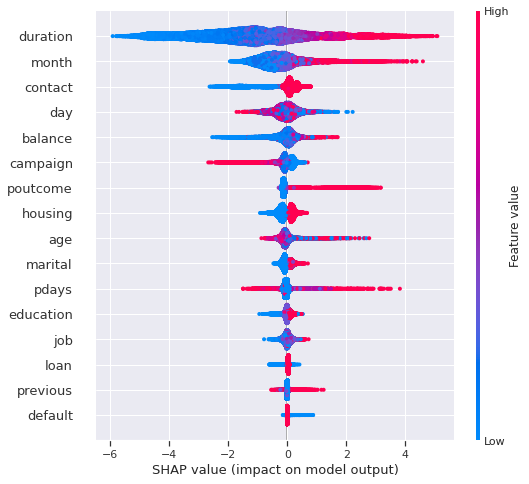

In [54]:
"""
Visualizando sumário para interpretação das
características que mais impactam o modelo
"""
shap.summary_plot(shap_values, X_encoded)

**Comentários:** Analisando a importância das variáveis podemos comprovar algumas observações tidas durante a análise dos dados: uma duração longa é um fator fundamental para e retenção do cliente, clientes que foram contactados poucas vezes possuem uma probabilidade maior de comprar o produto, ganho anual mais alto aumenta a probabilidade do cliente, etc.

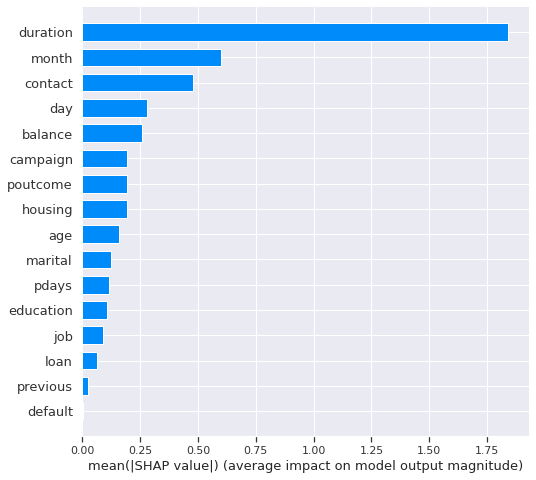

In [55]:
"""
Mesma visualização que a anterior, mas se levando em
consideração o impacto de acordo com o valor em si da
feature
"""
shap.summary_plot(shap_values, X_encoded, plot_type="bar")

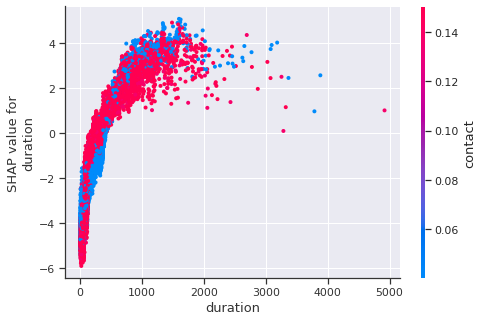

In [56]:
"""
Visualizando a distribuição do impacto na variável mais
importante do modelo
"""
shap.dependence_plot("duration", shap_values, X_encoded)

## Balanceamento

Utilizando técnica de balanceamento

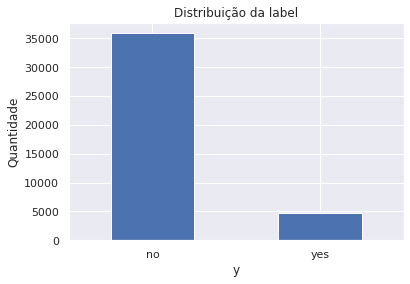

In [57]:
"""
Visualizando a distribuição da label para julgar
se é necessário utilizar técnicas para o balanceamento
das classes
"""
plt.xlabel("y")
plt.ylabel("Quantidade")

data['y'].value_counts().plot.bar(title='Distribuição da label', rot=0);

**Comentários:** Percebe-se um desbalanceamento perceptível na base de dados, portanto, utilizarei uma técnica de balanceamento para amenizar este cenário

In [58]:
"""
Adicionando uma técnica de encoding ao pipeline
"""
sampling = SMOTEENN()

encoder = ce.TargetEncoder(cols=categorical_columns)

model = XGBClassifier()

pipeline = Pipeline([('encoder', encoder), ('sampling', sampling), ('clf', model)])

**Comentários:** Utilizarei as técnicas SMOTE + ENN combinadas para diminuir o número de indivíduos da classe 0 e aumentar o número de indivíduos da classe 1

In [59]:
"""
Amostrando a base e dividindo em treino e teste
"""

data = data.sample(frac=1)

X = data.drop(columns='y')
y = data['y'].apply(lambda x: 0 if x == 'no' else 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y)

In [60]:
"""
Perfomando o treinamento e predição
"""

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)

In [61]:
"""
Calculando métricas
"""
get_results(predictions, y_test)

{'precision': 0.7348643006263048,
 'recall': 0.5191740412979351,
 'fscore': 0.6084701815038893,
 'roc_auc': 0.7408609811326007}

**Comentários:** Percebe-se uma melhora no resultado

## Transformação nos dados numéricos

In [62]:
"""
Realizando transformação logarítmica em algumas colunas
"""
data['balance_log'] = data['balance'].transform(np.log)
data['age_log'] = data['age'].transform(np.log)
data['pdays_log'] = data['pdays'].transform(np.log)
data['duration_log'] = data['duration'].transform(np.log)
data['previous_log'] = data['previous'].transform(np.log)
data['campaign_log'] = data['campaign'].transform(np.log)

**Comentários:** Utilizarei a transformação logarítmica nos dados, já que a distribuição das variáveis possui viés, com isso, a transformação tende a diminuir o efeito de outliers

In [63]:
"""
Buscando o nome das colunas categóricas, para utilização
de técnica de encoding
"""
categorical_columns = data.select_dtypes(include='object').columns.to_list()
categorical_columns.remove('y')

In [64]:
"""
Colunas em que será realizado o encoding
"""
categorical_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [65]:
"""
Adicionando uma técnica de encoding ao pipeline
"""
sampling = SMOTEENN()

encoder = ce.TargetEncoder(cols=categorical_columns)

model = XGBClassifier()

pipeline = Pipeline([('encoder', encoder), ('sampling', sampling), ('clf', model)])

In [69]:
"""
Amostrando a base e dividindo em treino e teste
"""

data = data.sample(frac=1)
data = data.dropna()
data = data.loc[~(data['balance_log'] == -np.inf)]

X = data.drop(columns=['balance', 'age', 'pdays', 'duration', 'previous', 'campaign', 'y'])
y = data['y'].apply(lambda x: 0 if x == 'no' else 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y)

In [70]:
"""
Perfomando o treinamento e predição
"""

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)

In [71]:
"""
Calculando métricas
"""
get_results(predictions, y_test)

{'precision': 0.8333333333333334,
 'recall': 0.6308411214953271,
 'fscore': 0.7180851063829788,
 'roc_auc': 0.7850151553422581}

**Comentários:** As novas características demonstram uma melhora perceptível no resultado

## Seleção de características

In [72]:
"""
Amostrando a base e dividindo em treino e teste
"""

data = data.sample(frac=1)

X = data.drop(columns=['balance', 'age', 'pdays', 'duration', 'y'])
y = data['y'].apply(lambda x: 0 if x == 'no' else 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y)

In [73]:
"""
Fit do classificador para interpretação
"""
encoder = ce.target_encoder.TargetEncoder(cols=categorical_columns)

X_encoded = encoder.fit_transform(X_train, y_train)

model = RandomForestClassifier()

selector = RFECV(model, step=1, cv=5, scoring='f1')

selector.fit(X_encoded, y_train)

RFECV(cv=5, estimator=RandomForestClassifier(), scoring='f1')

**Comentários:** Optei por utilizar o algortimo *recursive feature elimination* para performar a seleção das características

In [74]:
"""
Analisando resultado do RFE
"""
selector.support_

array([False, False, False, False, False, False, False,  True,  True,
       False, False,  True,  True,  True,  True,  True, False, False])

In [79]:
"""
Utilizando somente colunas selecionadas pelo RFE
"""
X = X[X.columns[selector.support_]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y)

In [86]:
"""
Verificando quais colunas foram selecionadas
"""
X.columns.to_list()

['day',
 'month',
 'poutcome',
 'balance_log',
 'age_log',
 'pdays_log',
 'duration_log']

In [80]:
"""
Selecionando colunas categóricas que sobraram
"""
categorical_columns = X.select_dtypes(include='object').columns

In [81]:
"""
Adicionando uma técnica de encoding ao pipeline
"""
sampling = SMOTEENN()

encoder = ce.TargetEncoder(cols=categorical_columns)

model = XGBClassifier()

pipeline = Pipeline([('encoder', encoder), ('sampling', sampling), ('clf', model)])

In [82]:
"""
Perfomando o treinamento e predição
"""

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)

In [83]:
"""
Calculando métricas
"""
get_results(predictions, y_test)

{'precision': 0.845679012345679,
 'recall': 0.6199095022624435,
 'fscore': 0.7154046997389034,
 'roc_auc': 0.7813506321380868}

**Comentários:** Não percebe-se uma melhora nos resultados, já que este está dentro do desvio padrão do anterior. Portanto, selecionar ou não as características não parece uma decisão forte, principalmente tendo em vista o número reduzido de variáveis

## Análise dos resultados

In [97]:
"""
Amostrando a base e dividindo em treino e teste
"""

data = data.sample(frac=1)
data = data.dropna()

X = data.drop(columns=['balance', 'age', 'pdays', 'duration', 'previous', 'campaign', 'y'])
y = data['y'].apply(lambda x: 0 if x == 'no' else 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y)

In [98]:
"""
Selecionando colunas categóricas que sobraram
"""
categorical_columns = X.select_dtypes(include='object').columns

In [99]:
"""
Adicionando uma técnica de encoding ao pipeline
"""
sampling = SMOTEENN()

encoder = ce.TargetEncoder(cols=categorical_columns)

model = XGBClassifier()

pipeline = Pipeline([('encoder', encoder), ('sampling', sampling), ('clf', model)])

In [100]:
"""
Perfomando o treinamento e predição
"""
pipeline.fit(X_train, y_train)

probas = pipeline.predict_proba(X_test)

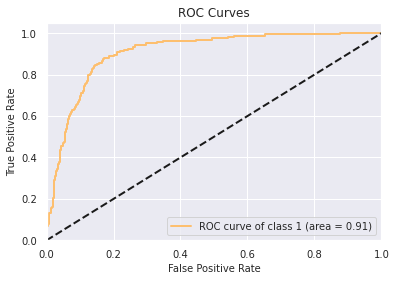

In [101]:
"""
Plotando curva ROC
"""

skplt.metrics.plot_roc(y_test, probas, cmap='Paired', classes_to_plot=1, plot_micro=False, plot_macro=False);

**Comentários:** A curva roc mostra que o modelo consegue distinguir bem os clientes que compram dos que não compram o produto. Com um **índice gini acima de 80%**

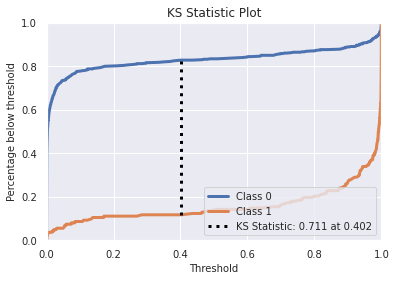

In [102]:
"""
Plotando o gráfico para o teste de Kolmogorov-Smirnov
"""

skplt.metrics.plot_ks_statistic(y_test, probas);

**Comentários:** Com o teste de Kolmogorov-Smirnov podemos perceber que o ponto com maior distinção entre as taxas de verdadeiro positivo e de falso positivo no modelo, se dá com o limiar de **40.2%** na probabilidade do classificador

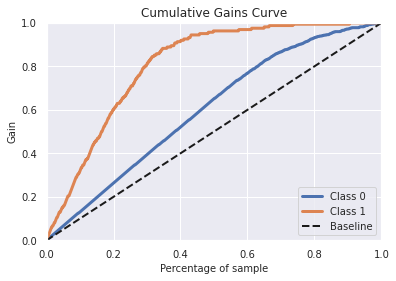

In [103]:
"""
Plotando o gráfico de curva de ganho acumulativo
"""

skplt.metrics.plot_cumulative_gain(y_test, probas);

**Comentários:** O gráfico de ganho acumulativo nos mostra que **atingindo os ~30% das observações, o modelo garantirá que 80% dos clientes retidos estejam nesse grupo**, enquanto a seleção aleatória forneceria apenas 20% destes indivíduos.

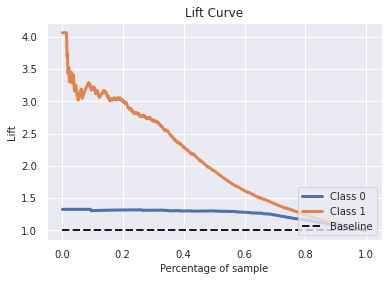

In [104]:
"""
Plotando lift curve
"""

skplt.metrics.plot_lift_curve(y_test, probas);

**Comentários:** Complementar ao ganho acumulativo, a cura de eleveção nos mostra que se a incidência média de alvos for 20%, o aumento será 3. Portanto, **o modelo permite abordar três vezes mais possíveis compradores**, em comparação com a escolha aleatória.

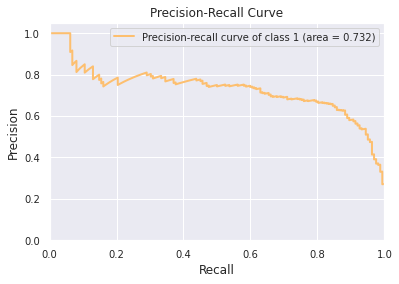

In [105]:
"""
Plotando o gráfico precision x recall
"""

skplt.metrics.plot_precision_recall(y_test, probas, plot_micro=False, cmap='Paired', classes_to_plot=1);

**Comentários:** A curva precisão x sensibilidade nos mostra que um balanço razoável entre essas duas métricas, tendo em vista que se trata de um problema com desbalanceamento razoável

## Over-fitting

Utilizando validação cruzada para minimizar a possibilidade de over-fitting no modelo

In [106]:
"""
Amostrando a base
"""

data = data.sample(frac=1)
data = data.dropna()

X = data.drop(columns=['balance', 'age', 'pdays', 'duration', 'previous', 'campaign', 'y'])
y = data['y'].apply(lambda x: 0 if x == 'no' else 1)

In [107]:
"""
Buscando o nome das colunas categóricas, para utilização
de técnica de encoding
"""
categorical_columns = X.select_dtypes(include='object').columns.to_list()

In [108]:
"""
Pipeline final
"""
sampling = SMOTEENN()

encoder = ce.TargetEncoder(cols=categorical_columns)

model = XGBClassifier()

pipeline = Pipeline([('encoder', encoder), ('sampling', sampling), ('clf', model)])

In [109]:
"""
Utilizando validação cruzada para adicionar robustez 
ao resultado
"""
results = cross_validate(pipeline, X, y, cv=5, scoring=['precision', 'recall', 'f1', 'roc_auc'])

In [110]:
"""
Plotando a média e desvio padrão das métricas
"""
print('precision: {0} ({1})'.format(np.mean(results['test_precision']), np.std(results['test_precision'])))
print('recall: {0} ({1})'.format(np.mean(results['test_recall']), np.std(results['test_recall'])))
print('fscore: {0} ({1})'.format(np.mean(results['test_f1']), np.std(results['test_f1'])))
print('roc_auc: {0} ({1})'.format(np.mean(results['test_roc_auc']), np.std(results['test_roc_auc'])))

precision: 0.6088004799558994 (0.00489915063732828)
recall: 0.8160990712074303 (0.007977770109427346)
fscore: 0.6973517705024486 (0.004994771938628849)
roc_auc: 0.8984466765480356 (0.0038288335160647424)


## Conjunto de dados com predições

In [113]:
"""
Criando coluna de predições na base
"""
data['predictions'] = cross_val_predict(pipeline, X, y, cv=5)

In [115]:
"""
Salvando csv com coluna de predição no csv original
"""
data.to_csv('../data/campaigns_predictions.csv', index=False)

**Comentários:** Salvando o arquivo com as predições na base sem enconding e sem excluir as variáveis que foram transoformadas